<a href="https://colab.research.google.com/github/CrowdSalat/ann-dynamical-systems/blob/master/baseline_model_scaled_more_data_batchnorm_order.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# overview

Uses actions and an input state to predict the output state.

History mse
mse all
History mae
mae all
mse per target scaled
mse per target unscaled

vllt deutliche kleineres model
batch norm after acitivation

# imports

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [1]:
import pandas as pd
import numpy as np
import os
import sys
import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


import tensorflow as tf
print(tf.__version__)
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import *
from tensorflow.keras import metrics

1.15.0-rc3


# mount drive

In [0]:
file = 'dataset_all_01.csv'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

root_dir = '/content/drive/My Drive/xplane_data' 
os.chdir(root_dir)
print ('working dir: ' + os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
working dir: /content/drive/My Drive/xplane_data


# load and prepare data

## define features (actions & states)
actions and states at time t are the input for the network.

the states at time t + 1 are the desired output of the network.


In [5]:
col_m_time      = '   missn,_time '
col_t_time      = '   _totl,_time '
col_yaw_v       = '   ____Q,rad/s '

col_yaw_deg     = '   _beta,__deg '
col_roll_deg    = '   _roll,__deg '
col_roll_v      = '   ____R,rad/s '
col_pitch_deg   = '   pitch,__deg '
col_pitch_v     = '   ____P,rad/s '
col_alt         = '   __alt,ftmsl '
col_vv          = '   __VVI,__fpm '
col_v           = '   Vtrue,_ktas '
col_rpm_prop    = '   rpm_1,_prop '
col_throttle     = '   thro1,_part '

cols_state = [ 
    col_yaw_v,
    col_yaw_deg,
    col_roll_deg,
    col_roll_v,
    col_pitch_deg,
    col_pitch_v,
    col_vv,
    col_alt,
    col_v,
    col_rpm_prop,
    col_throttle,
]

cols_time = [
    col_m_time,
    col_t_time,
]

col_elev_servo                  = '   _elev,servo '
col_ailrn_servo                  = '   ailrn,servo '
col_ruddr_servo                  = '   ruddr,servo '

cols_action = [
    col_elev_servo,
    col_ailrn_servo,
    col_ruddr_servo
]

# all input columns
cols_features = []
cols_features.extend(cols_state)
cols_features.extend(cols_action)

# orga column
col_dataset_index = 'dataset_index'
col_maneuver_index = 'maneuver_index'
col_maneuver_name = 'maneuver_name'
col_maneuver_datapoint_index = 'maneuver_datapoint_index'
col_maneuver_type = 'maneuver_type'


label_prefix = 't+1_'
cols_label = [label_prefix + col_state for col_state in cols_state]
print(cols_label)


['t+1_   ____Q,rad/s ', 't+1_   _beta,__deg ', 't+1_   _roll,__deg ', 't+1_   ____R,rad/s ', 't+1_   pitch,__deg ', 't+1_   ____P,rad/s ', 't+1_   __VVI,__fpm ', 't+1_   __alt,ftmsl ', 't+1_   Vtrue,_ktas ', 't+1_   rpm_1,_prop ', 't+1_   thro1,_part ']


## load data

In [6]:
def load_xplane_csv(csv_path, columns):
    return pd.read_csv(csv_path, delimiter=',', usecols = columns, 
                       float_precision='high')

df_features = load_xplane_csv(file, cols_features)

df_labels = load_xplane_csv(file, cols_label)

print(len(df_features))
print(len(df_labels))
assert(len(df_features) == len(df_labels))


477893
477893


## drop nan in features and labels

drop nan rows in both features and in labels

In [7]:
df_nan = df_labels.isna().any(axis=1)

for i in range(0, len(df_nan)):
  if df_nan[i] == True:
    df_features.drop(index=i, inplace=True)

df_labels.dropna(inplace=True)

print(len(df_features))
print(len(df_labels))

477290
477290


In [0]:
def split_train_test(dataset):
  train_size = int(len(dataset) * 0.67)
  test_size = len(dataset) - train_size
  train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
  return train, test


## split data

In [0]:
features = df_features.values
labels = df_labels.values

In [0]:
train_X, test_X, train_Y, test_Y  = train_test_split(features,labels, test_size=0.2, random_state=42)

In [11]:
print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(381832, 14)
(381832, 11)
(95458, 14)
(95458, 11)


## scale data

In [0]:
feature_scaler = MinMaxScaler()
feature_scaler.fit(train_X)

train_X = feature_scaler.transform(train_X)
test_X = feature_scaler.transform(test_X)


In [0]:
label_scaler = MinMaxScaler()
label_scaler.fit(train_Y)

train_Y = label_scaler.transform(train_Y)
test_Y = label_scaler.transform(test_Y)

In [0]:
# create scaled df
scaled_df_features = pd.DataFrame(feature_scaler.transform(df_features), columns=df_features.columns)
scaled_df_labels = pd.DataFrame(label_scaler.transform(df_labels), columns=df_labels.columns)

In [15]:
df_features.describe()

,"Vtrue,_ktas","__VVI,__fpm","____Q,rad/s","____P,rad/s","____R,rad/s","pitch,__deg","_roll,__deg","_beta,__deg","__alt,ftmsl","thro1,_part","rpm_1,_prop","_elev,servo","ailrn,servo","ruddr,servo"
count,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.0
mean,119.567353,31.868167,0.003814,-0.000023,-0.001840,-0.653563,-0.791051,0.006402,2714.494715,0.837601,2490.420838,-0.000023,-0.014557,0.0
std,10.113279,274.992679,0.007108,0.017348,0.023905,1.684671,8.876412,0.137679,1357.480837,0.082115,127.216137,0.002304,0.022662,0.0
min,66.424780,-1917.888180,-0.039450,-0.109810,-0.054820,-9.313510,-23.851520,-0.689970,805.092900,0.796080,2106.257810,-0.089790,-0.159740,0.0
25%,116.120002,-38.766265,-0.000010,-0.000410,-0.010880,-1.284538,-4.070882,-0.082300,1411.464812,0.796080,2424.051882,-0.000110,-0.017030,0.0
50%,118.825780,0.342395,0.001120,-0.000000,-0.000020,-0.787040,-0.104720,0.004390,2622.403565,0.796080,2458.394655,0.000000,-0.015220,0.0
75%,122.744895,165.376283,0.010170,0.000390,0.000847,-0.151363,0.212638,0.073260,3896.206053,0.796080,2504.543460,0.000070,-0.011370,0.0
max,155.436650,978.538330,0.041650,0.111310,0.055400,11.796170,25.924920,0.353550,5080.888180,1.000000,2811.808840,0.045100,0.124900,0.0


In [16]:
scaled_df_features.describe()

,"Vtrue,_ktas","__VVI,__fpm","____Q,rad/s","____P,rad/s","____R,rad/s","pitch,__deg","_roll,__deg","_beta,__deg","__alt,ftmsl","thro1,_part","rpm_1,_prop","_elev,servo","ailrn,servo","ruddr,servo"
count,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,4.772900e+05,477290.000000,477290.000000,477290.000000,477290.000000,477290.0
mean,0.597028,0.673159,0.533466,0.496506,0.480678,0.410273,0.463281,0.667330,4.465606e-01,0.203613,0.544487,0.665484,0.510059,0.0
std,0.113617,0.094942,0.087647,0.078456,0.216880,0.079813,0.178326,0.131938,3.174807e-01,0.402681,0.180307,0.017080,0.079616,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.566223e-07,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.558299,0.648773,0.486313,0.494754,0.398657,0.380380,0.397390,0.582327,1.418146e-01,0.000000,0.450420,0.664838,0.501370,0.0
50%,0.588697,0.662275,0.500247,0.496608,0.497187,0.403949,0.477069,0.665402,4.250228e-01,0.000000,0.499095,0.665653,0.507729,0.0
75%,0.632726,0.719253,0.611837,0.498372,0.505058,0.434065,0.483445,0.731399,7.229333e-01,0.000000,0.564503,0.666172,0.521255,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000090,1.000000,1.000000,1.000001e+00,1.000000,1.000000,1.000000,1.000000,0.0


In [17]:
df_labels.describe()

,"t+1_ ____Q,rad/s","t+1_ _beta,__deg","t+1_ _roll,__deg","t+1_ ____R,rad/s","t+1_ pitch,__deg","t+1_ ____P,rad/s","t+1_ __VVI,__fpm","t+1_ __alt,ftmsl","t+1_ Vtrue,_ktas","t+1_ rpm_1,_prop","t+1_ thro1,_part"
count,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000
mean,0.003815,0.006402,-0.791050,-0.001840,-0.653565,-0.000023,31.866864,2714.494657,119.567394,2490.421446,0.837601
std,0.007105,0.137680,8.876411,0.023905,1.684673,0.017348,274.991234,1357.480898,10.113312,127.216670,0.082115
min,-0.038680,-0.689970,-23.851520,-0.054820,-9.313510,-0.109810,-1917.888180,805.092900,66.424780,2106.257810,0.796080
25%,-0.000010,-0.082300,-4.070882,-0.010888,-1.284488,-0.000410,-38.766265,1411.464812,116.120015,2424.051882,0.796080
50%,0.001120,0.004390,-0.104720,-0.000020,-0.787045,0.000000,0.342395,2622.403565,118.825780,2458.394900,0.796080
75%,0.010160,0.073260,0.212860,0.000850,-0.151363,0.000390,165.372623,3896.206053,122.745007,2504.543950,0.796080
max,0.041650,0.353550,25.924920,0.055400,11.796170,0.111310,978.538330,5080.888180,155.436650,2811.808840,1.000000


In [18]:
scaled_df_labels.describe()

,"t+1_ ____Q,rad/s","t+1_ _beta,__deg","t+1_ _roll,__deg","t+1_ ____R,rad/s","t+1_ pitch,__deg","t+1_ ____P,rad/s","t+1_ __VVI,__fpm","t+1_ __alt,ftmsl","t+1_ Vtrue,_ktas","t+1_ rpm_1,_prop","t+1_ thro1,_part"
count,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000
mean,0.529000,0.667368,0.463281,0.480678,0.410236,0.496619,0.673159,0.446561,0.597028,0.544487,0.203615
std,0.088447,0.131945,0.178326,0.216880,0.079806,0.078474,0.094942,0.317480,0.113618,0.180308,0.402682
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.481389,0.582361,0.397390,0.398589,0.380348,0.494866,0.648773,0.141815,0.558299,0.450420,0.000000
50%,0.495456,0.665440,0.477069,0.497187,0.403913,0.496720,0.662275,0.425023,0.588697,0.499095,0.000000
75%,0.607992,0.731442,0.483449,0.505081,0.434026,0.498485,0.719252,0.722933,0.632727,0.564504,0.000000
max,1.000000,1.000058,1.000000,1.000000,1.000000,1.000226,1.000000,1.000000,1.000000,1.000000,1.000000


# train models

## define callbacks

In [0]:
def prepare_tensorboard_callback(model_name=''):
  logs_base_dir = "./tensorbaord_logs"
  os.makedirs(logs_base_dir, exist_ok=True)
  log_dir = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '_' + model_name
  logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
  return tensorboard_callback


In [0]:
def prepare_checkpoint_callback(model_name=datetime.datetime.now().strftime("%Y%m%d-%H%M%S")):
  checkpoint_base_dir = './checkpoints'
  os.makedirs(checkpoint_base_dir, exist_ok=True)

  filepath = os.path.join(checkpoint_base_dir, 'cp_'+model_name)

  cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                  save_weights_only=True,
                                                  verbose=1)
  return cp_callback

## baseline model



#baseline with orrect batch norm

In [21]:
features_nr = train_X.shape[1]
target_nr = train_Y.shape[1]

baseline_model = keras.Sequential()

baseline_model.add(Dense(1200,input_shape=(features_nr,), 
                         kernel_initializer='he_uniform'))
baseline_model.add(ReLU())
baseline_model.add(BatchNormalization())

baseline_model.add(Dense(600, kernel_initializer='he_uniform'))
baseline_model.add(ReLU())
baseline_model.add(BatchNormalization())

baseline_model.add(Dense(600, kernel_initializer='he_uniform'))
baseline_model.add(ReLU())
baseline_model.add(BatchNormalization())

baseline_model.add(Dense(target_nr,activation='linear'))

baseline_model.compile(optimizer='adam',
                       loss='mean_squared_error',
                       metrics=[metrics.mean_squared_error, 
                                metrics.mean_absolute_error, 
                                metrics.mean_absolute_percentage_error])

baseline_model.summary()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1200)              18000     
_________________________________________________________________
re_lu (ReLU)                 (None, 1200)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1200)              4800      
_________________________________________________________________
dense_1 (Dense)              (None, 600)               720600    
_________________________________________________________________
re_lu_1 (ReLU)               (None, 600)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 600)               2400      
_________________________________________

In [22]:
callbacks = [
            #prepare_checkpoint_callback(model_name='baseline'),
            #prepare_tensorboard_callback()
            ]

baseline_history = baseline_model.fit(train_X,
                                      train_Y,
                                      epochs=10,
                                      validation_data=(test_X, test_Y),
                                      verbose=2,
                                      callbacks=callbacks
                                      )


Train on 381832 samples, validate on 95458 samples
Epoch 1/10
381832/381832 - 107s - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0491 - mean_absolute_percentage_error: 5032317.5000 - val_loss: 0.0033 - val_mean_squared_error: 0.0033 - val_mean_absolute_error: 0.0447 - val_mean_absolute_percentage_error: 2508731.2500
Epoch 2/10
381832/381832 - 104s - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 4419807.0000 - val_loss: 0.0075 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0476 - val_mean_absolute_percentage_error: 8956590.0000
Epoch 3/10
381832/381832 - 104s - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0314 - mean_absolute_percentage_error: 4340941.5000 - val_loss: 9.6552e-04 - val_mean_squared_error: 9.6552e-04 - val_mean_absolute_error: 0.0214 - val_mean_absolute_percentage_error: 1438950.1250
Epoch 4/10
381832/381832 - 106s - loss: 0.0017 - mean_squared_error: 0.

In [0]:
baseline_model.save_weights('./checkpoints/baseline_scaled_more_data_batchnorm_end')

## visualize

In [0]:
def save_plots_before_show(diagramm_name):
  diagramm_folder = './diagramms'

  if not os.path.exists(diagramm_folder):
      os.makedirs(diagramm_folder)

  plt.savefig(diagramm_folder + '/' + diagramm_name +'.pdf')
  plt.savefig(diagramm_folder + '/' + diagramm_name +'.svg')
  plt.savefig(diagramm_folder + '/' + diagramm_name +'.png')

def plot_history(histories, key='mean_squared_error', file_name=''):
  plt.figure(figsize=(16,10))

  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.yscale("log")
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])
  save_plots_before_show(file_name+'_'+key)
  plt.show()

In [0]:
#baseline_model.load_weights('./checkpoints/baseline_scaled_more_data_small_end')


### Test & Training MSE

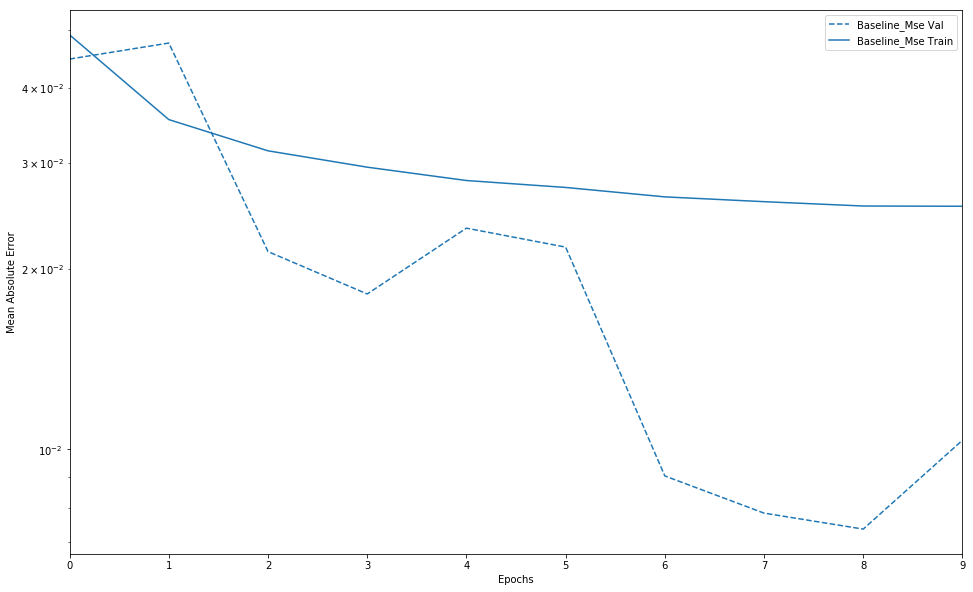

In [25]:
plot_history([('baseline_mse', baseline_history),],
              key='mean_absolute_error',
             file_name='scaled_more_data_small_mea')


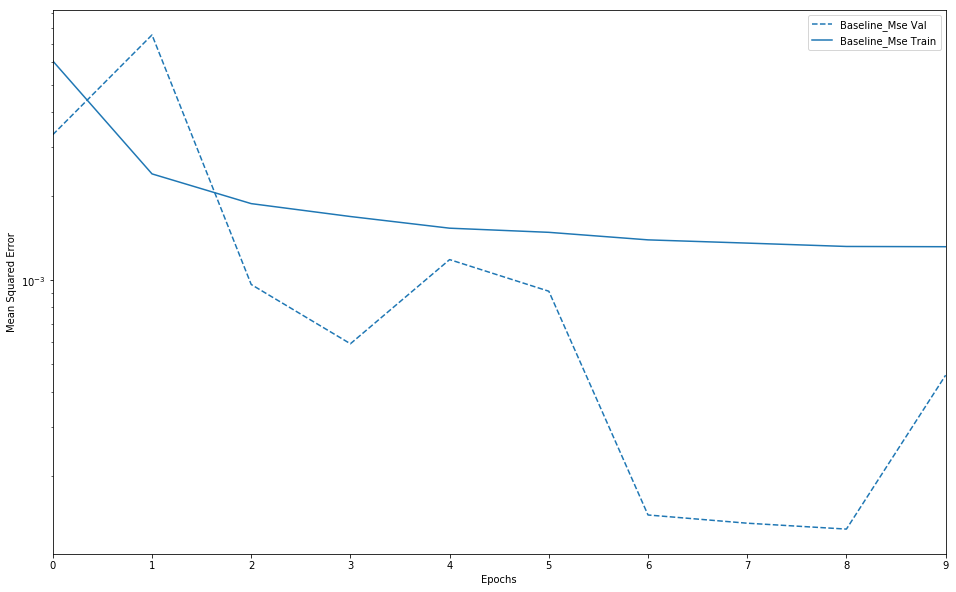

In [26]:
plot_history([('baseline_mse', baseline_history),],
              key='mean_squared_error',
             file_name='scaled_more_data_small_msa')


In [27]:
baseline_mse = baseline_model.evaluate(test_X, test_Y)[0]
print('baseline_mse '+  str(baseline_mse))


95458/95458 [==============================] - 9s 94us/sample - loss: 4.5769e-04 - mean_squared_error: 4.5769e-04 - mean_absolute_error: 0.0104 - mean_absolute_percentage_error: 1067223.7500
baseline_mse 0.00045769043077007154



### MSE per target (scaled)

In [0]:
from sklearn.metrics import mean_squared_error

def mse(model):
  pred_Y = model.predict(test_X)
  mse = mean_squared_error(test_Y, pred_Y, multioutput='raw_values')
  
  mse_per_feature = pd.DataFrame(data=mse.reshape(1,-1),    # values
              index=['mse'],     # index
              columns=df_labels.columns)  #  column names
  return scaled_df_labels.describe().append(mse_per_feature)


In [29]:
mses_baseline = mse(baseline_model)
mses_baseline.head(20)

,"t+1_ ____Q,rad/s","t+1_ _beta,__deg","t+1_ _roll,__deg","t+1_ ____R,rad/s","t+1_ pitch,__deg","t+1_ ____P,rad/s","t+1_ __VVI,__fpm","t+1_ __alt,ftmsl","t+1_ Vtrue,_ktas","t+1_ rpm_1,_prop","t+1_ thro1,_part"
count,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000
mean,0.529000,0.667368,0.463281,0.480678,0.410236,0.496619,0.673159,0.446561,0.597028,0.544487,0.203615
std,0.088447,0.131945,0.178326,0.216880,0.079806,0.078474,0.094942,0.317480,0.113618,0.180308,0.402682
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.481389,0.582361,0.397390,0.398589,0.380348,0.494866,0.648773,0.141815,0.558299,0.450420,0.000000
50%,0.495456,0.665440,0.477069,0.497187,0.403913,0.496720,0.662275,0.425023,0.588697,0.499095,0.000000
75%,0.607992,0.731442,0.483449,0.505081,0.434026,0.498485,0.719252,0.722933,0.632727,0.564504,0.000000
max,1.000000,1.000058,1.000000,1.000000,1.000000,1.000226,1.000000,1.000000,1.000000,1.000000,1.000000
mse,0.000228,0.000191,0.000191,0.000245,0.001770,0.000275,0.000671,0.000329,0.000322,0.000293,0.000519


### MSE per target (unscaled)

In [0]:
def mse_denormalized(model):
  pred_Y = model.predict(test_X)
  unscaled_pred_Y = label_scaler.inverse_transform(pred_Y)
  unscaled_test_Y = label_scaler.inverse_transform(test_Y)
  mse = mean_squared_error(unscaled_test_Y, unscaled_pred_Y, multioutput='raw_values')


  mse_per_feature = pd.DataFrame(data=mse.reshape(1,-1),    # values
              index=['mse'],     # index
              columns=df_labels.columns)  #  column names
  return df_labels.describe().append(mse_per_feature)


In [31]:
mse_denormalized(baseline_model).head(20)


,"t+1_ ____Q,rad/s","t+1_ _beta,__deg","t+1_ _roll,__deg","t+1_ ____R,rad/s","t+1_ pitch,__deg","t+1_ ____P,rad/s","t+1_ __VVI,__fpm","t+1_ __alt,ftmsl","t+1_ Vtrue,_ktas","t+1_ rpm_1,_prop","t+1_ thro1,_part"
count,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000,477290.000000
mean,0.003815,0.006402,-0.791050,-0.001840,-0.653565,-0.000023,31.866864,2714.494657,119.567394,2490.421446,0.837601
std,0.007105,0.137680,8.876411,0.023905,1.684673,0.017348,274.991234,1357.480898,10.113312,127.216670,0.082115
min,-0.038680,-0.689970,-23.851520,-0.054820,-9.313510,-0.109810,-1917.888180,805.092900,66.424780,2106.257810,0.796080
25%,-0.000010,-0.082300,-4.070882,-0.010888,-1.284488,-0.000410,-38.766265,1411.464812,116.120015,2424.051882,0.796080
50%,0.001120,0.004390,-0.104720,-0.000020,-0.787045,0.000000,0.342395,2622.403565,118.825780,2458.394900,0.796080
75%,0.010160,0.073260,0.212860,0.000850,-0.151363,0.000390,165.372623,3896.206053,122.745007,2504.543950,0.796080
max,0.041650,0.353550,25.924920,0.055400,11.796170,0.111310,978.538330,5080.888180,155.436650,2811.808840,1.000000
mse,0.000001,0.000207,0.473661,0.000003,0.788797,0.000013,5631.376804,6020.216275,2.549204,145.851233,0.000022
